In [43]:
from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

In [44]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples,h,w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]
y = lfw_people.target

target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1177
n_features: 1850
n_classes: 6


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
n_components = 150

t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((n_components, h, w))
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print('done in %0.3fs' % (time() - t0))

done in 0.008s


In [47]:
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4,1e-1)
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
clf.best_estimator_

SVC(C=14487.756354396744, class_weight='balanced', gamma=0.0005853075723752803)

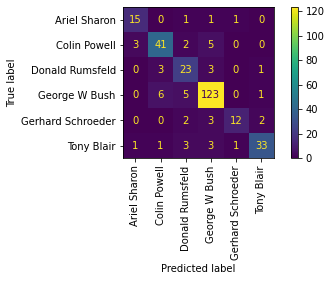

In [48]:
y_pred = clf.predict(X_test_pca)
ConfusionMatrixDisplay.from_estimator(
    clf,X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

In [49]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        v = plt.title(titles[i], size=12)
        plt.setp(v, color='w')
        plt.xticks(())
        plt.yticks(())

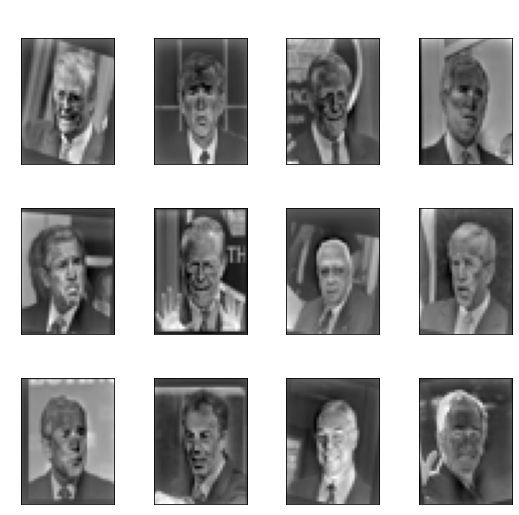

In [50]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ",1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ",1)[-1]
    return "predicted: %s\n true:      %s " % (pred_name, true_name)
prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)